# Notebook to generate plots for *"A Comparative Study of High-Order Singular Value Decomposition and Principal Component Analysis for Combustion Data Analysis"*

This notebook contains the code employed to generate the plots displayed in paper. The algorithms implemented is not optimal, but fully functional to understand the math behind the plots

In [106]:
import numpy as np
import json
import matplotlib.pyplot as plt
import tensorly as tl
from tensorly.tenalg import mode_dot, multi_mode_dot
import kagglehub
from tqdm import tqdm
import pandas as pd

## Data download and reading

In [107]:
reynolds_numbers = [8000]
paths = [f"sharmapushan/hydrogen-jet-{re}" for re in reynolds_numbers]
data_paths = [kagglehub.dataset_download(name) for name in paths]
#this part of the code is taken from multiple RE analysis
data_path = data_paths[0]
with open(data_paths[0] + '/info.json') as f:
    metadata = json.load(f)


In [108]:
# variable definition
subsample_x, subsample_y = 5, 5
Nx, Ny = metadata['global']['Nxyz']
n_snapshots = metadata['global']['snapshots'] - 1
Nx_sub = Nx // subsample_x
Ny_sub = Ny // subsample_y

component_names = ['YH', 'YH2', 'YO', 'YO2', 'YOH', 'YH2O', 'YHO2', 'YH2O2']
species_names = [cname[1:] for cname in component_names]
n_species = len(component_names)
molar_masses = {'YH': 1.0, 'YH2': 2.0, 'YO': 8.0, 'YO2': 16.0, 'YOH': 9.0, 'YH2O': 10.0, 'YHO2': 17.0, 'YH2O2': 18.0}
file_key_map = file_key_map = {'YH': 'YH filename', 'YH2': 'YH2 filename', 'YO': 'YO filename', 'YO2': 'YO2 filename',
                                'YOH': 'YOH filename', 'YH2O': 'YH2O filename', 'YHO2': 'YHO2 filename', 'YH2O2': 'YH2O2 filename'
}

Lx, Ly = 12.5, 15.6# domain size in D units

print(f"Grid: {Nx}x{Ny}, Subsampled: {Nx_sub}x{Ny_sub}")

Grid: 1600x2000, Subsampled: 320x400


In [109]:
# Data loading
# Since I work with only one tensor, I don't need dicts
tensor = np.zeros((Ny_sub, Nx_sub, n_species, n_snapshots))

for t_idx in tqdm(range(n_snapshots)):
    for new_idx, (comp_name, orig_idx) in enumerate(zip(component_names, range(n_species))):
        filename_key = file_key_map[comp_name]
        filename = metadata['local'][t_idx][filename_key]
        data = np.fromfile(f"{data_path}/{filename}", dtype='<f4').reshape(Ny, Nx)
        molar_data = data / molar_masses[comp_name]
        tensor[:, :, new_idx, t_idx] = molar_data[::subsample_x, ::subsample_y]
    
print(tensor.shape)
print("Data loading complete!")


100%|██████████| 200/200 [00:08<00:00, 24.34it/s]

(400, 320, 8, 200)
Data loading complete!


In [110]:
def scale_and_center_tensor(tensor, component_names = component_names, log_scale=True, 
                             std_scale=True, epsilon=1e-12):
    tensor_scaled = tensor.copy()  
    for c_idx, comp_name in enumerate(component_names):
        component_data = tensor_scaled[:, :, c_idx, :].copy()            
        if log_scale:
            component_data = np.log10(np.maximum(component_data, epsilon))
        if std_scale:
            mean_val = component_data.mean()
            std_val = component_data.std()                
            if std_val < epsilon:
                std_val = epsilon  # Prevent divide-by-zero
            component_data = (component_data - mean_val) / std_val
        tensor_scaled[:, :, c_idx, :] = component_data
    return tensor_scaled

tensor_scaled = scale_and_center_tensor(tensor)

### Visualization of tensor and tensor scaled

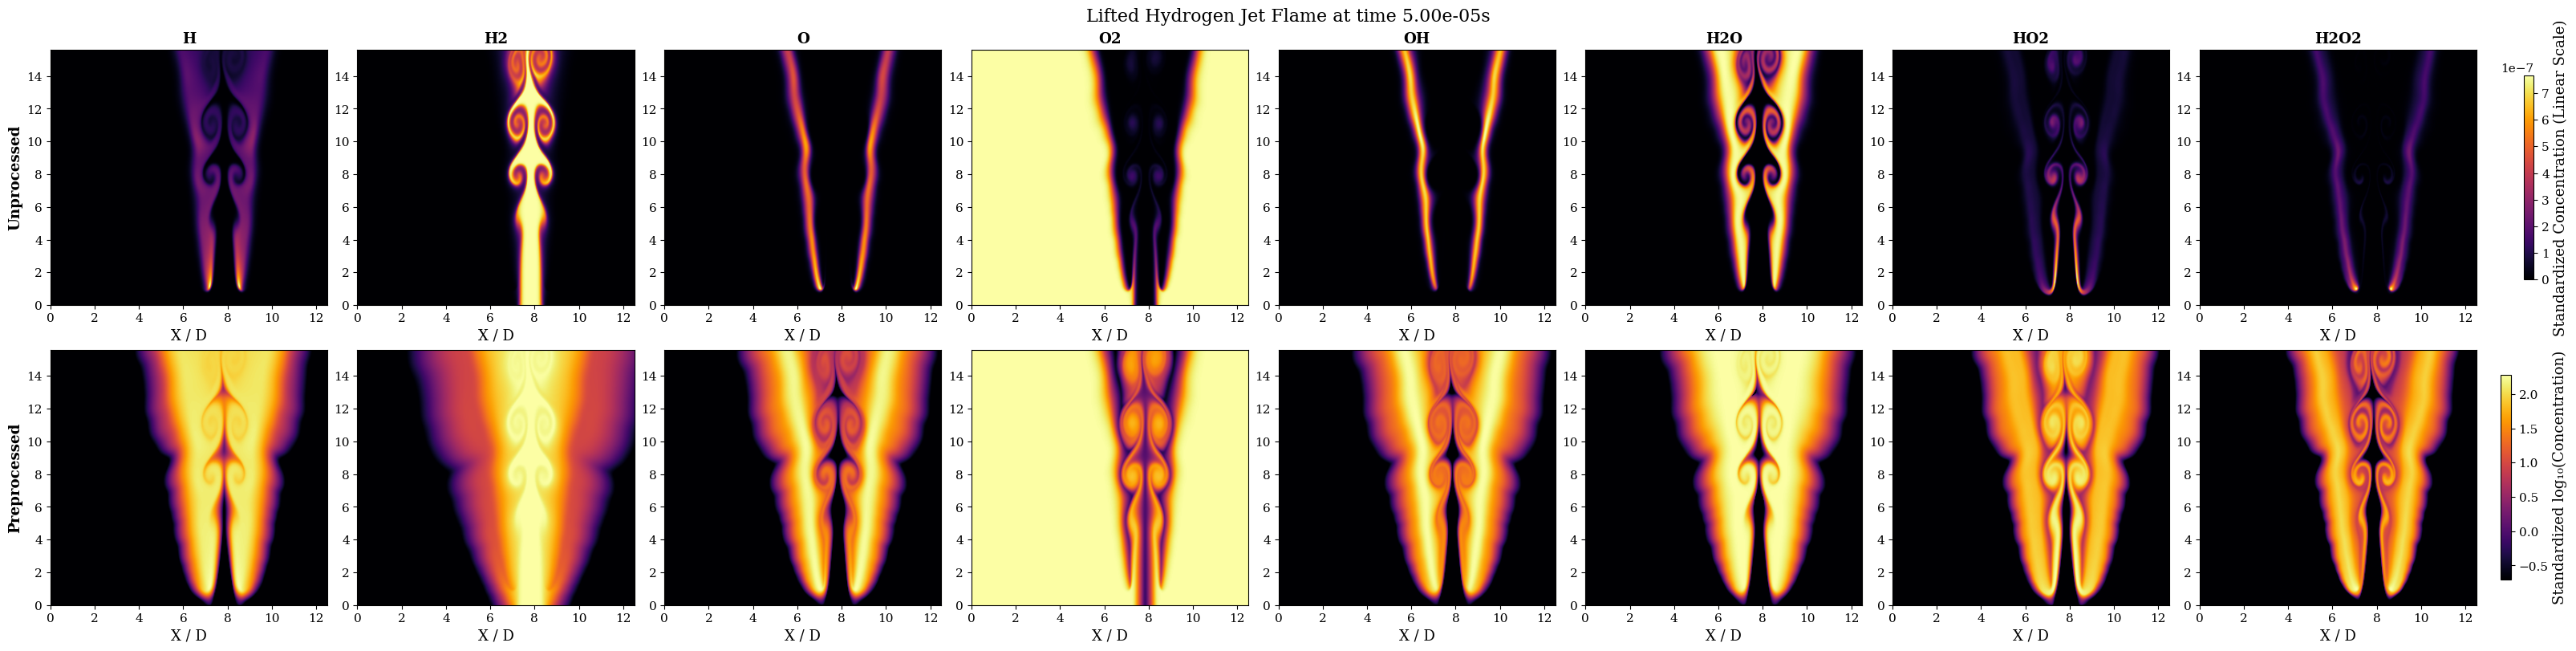

In [112]:
x = np.linspace(0, Lx, Nx_sub)
y = np.linspace(0, Ly, Ny_sub)
t = 10
time_conversion_factor = 5e-06

fig, axes = plt.subplots(2, 8, figsize=(32, 8), constrained_layout=True)
fig.suptitle(f"Lifted Hydrogen Jet Flame at time {t * time_conversion_factor:.2e}s", fontsize=16)

tensor_plot = tensor
tensor_plot_log = tensor_scaled


for idx in range(8):
    im = axes[0, idx].imshow(
        tensor_plot[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    #axes[0, idx].set_title(f"{component_names[idx][1:]}")
    axes[0, idx].set_xlabel("X / D")
    if idx == 0:
        axes[0, idx].set_ylabel("Y / D")

cbar1 = fig.colorbar(im, ax=axes[0, :], orientation='vertical', 
                      label="Standardized Concentration (Linear Scale)", 
                      pad=0.01, shrink=0.8)

for idx in range(8):
    im_log = axes[1, idx].imshow(
        tensor_plot_log[:, :, idx, t],
        cmap='inferno',
        origin='lower',
        extent=[0, Lx, 0, Ly],
        aspect='auto'
    )
    #axes[1, idx].set_title(f"{component_names[idx][1:]}")
    axes[1, idx].set_xlabel("X / D")
    if idx == 0:
        axes[1, idx].set_ylabel("Y / D")
cbar2 = fig.colorbar(im_log, ax=axes[1, :], orientation='vertical', 
                      label="Standardized log₁₀(Concentration)", 
                      pad=0.01, shrink=0.8)
cols = [component_name[1:] for component_name in component_names]
rows = ["Unprocessed", "Preprocessed"]
for ax, col in zip(axes[0], cols):
    ax.set_title(col,  size='large', fontweight = "bold")

for ax, row in zip(axes[:,0], rows):
    ax.set_ylabel(row, rotation=90, size='large', fontweight = "bold")

plt.savefig(fname='README_PLOTS/data_comparison.png')

plt.show()

## PCA 

In [63]:
#The axis is to keep PCA reproducible, i.e. always unfold in the same way regardless of the idx position of the chemical species
X = np.moveaxis(tensor_scaled, 2, -1).reshape(tensor_scaled.shape[0]*tensor_scaled.shape[1]*tensor_scaled.shape[3], tensor_scaled.shape[2])
U_PCA, sigma_PCA, V_PCA = np.linalg.svd(X, full_matrices=False)
loadings = V_PCA.T


## HOSVD

In [54]:
# Computed wit the definition
U_y, _, _ = np.linalg.svd(tl.unfold(tensor_scaled, mode=0), full_matrices=False)
U_x, _, _ = np.linalg.svd(tl.unfold(tensor_scaled, mode=1), full_matrices=False)
U_chem, _, _ = np.linalg.svd(tl.unfold(tensor_scaled, mode=2), full_matrices=False)
U_time, _, _ = np.linalg.svd(tl.unfold(tensor_scaled, mode=3), full_matrices=False)
core = multi_mode_dot(tensor_scaled, [U_y.T, U_x.T, U_chem.T, U_time.T], modes=[0, 1, 2, 3])

## Loadings equivalence

This was asserted in the paper, no plot was provided due to lack of space 

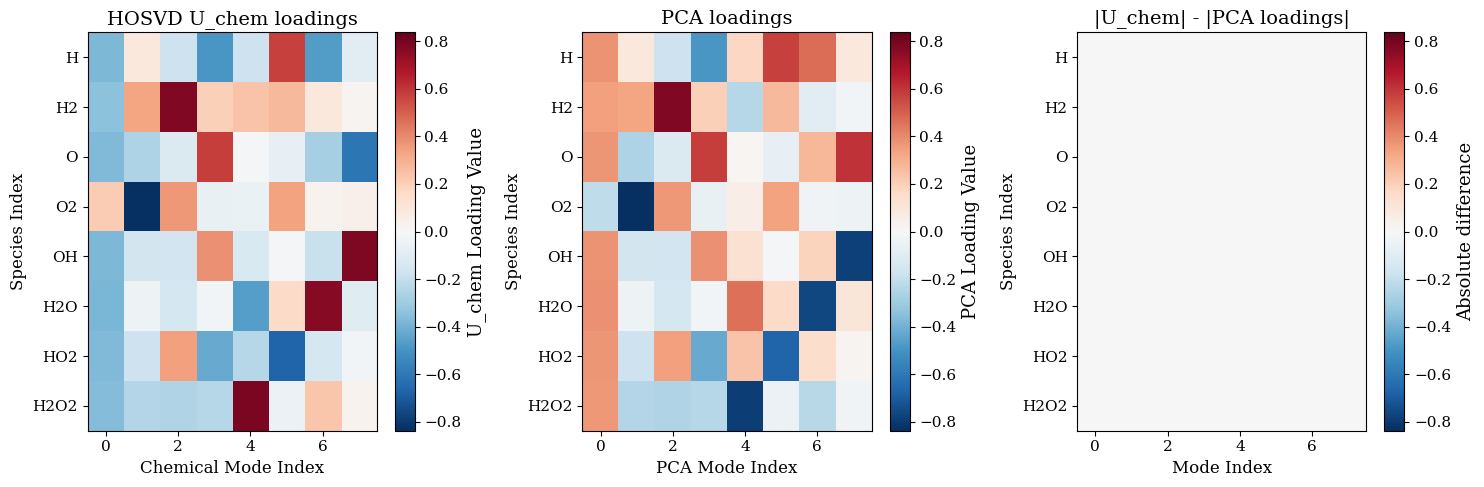

In [113]:
fig, axes = plt.subplots(1,3, figsize = (15, 5))
im = axes[0].imshow(U_chem, cmap='RdBu_r', aspect='auto', 
                    vmin=-np.abs(U_chem).max(), 
                    vmax=np.abs(U_chem).max())
axes[0].set_title("HOSVD U_chem loadings")

axes[0].set_ylabel('Species Index', fontsize=12)
axes[0].set_xlabel('Chemical Mode Index', fontsize=12)
axes[0].set_yticks(range(len(component_names)))
axes[0].set_yticklabels(species_names, ha='right')
plt.colorbar(im, ax=axes[0], label='U_chem Loading Value')
im = axes[1].imshow(loadings, cmap='RdBu_r', aspect='auto', 
                    vmin=-np.abs(U_chem).max(), 
                    vmax=np.abs(U_chem).max())
axes[1].set_title("PCA loadings")
axes[1].set_ylabel('Species Index', fontsize=12)
axes[1].set_xlabel('PCA Mode Index', fontsize=12)
axes[1].set_yticks(range(len(component_names)))
axes[1].set_yticklabels(species_names , ha='right')
plt.colorbar(im, ax=axes[1], label='PCA Loading Value')
diff = np.subtract(np.abs(U_chem), np.abs(loadings))
im = axes[2].imshow(diff, cmap='RdBu_r', aspect='auto', 
                    vmin=-np.abs(U_chem).max(), 
                    vmax=np.abs(U_chem).max())
axes[2].set_title("|U_chem| - |PCA loadings|")
axes[2].set_ylabel('Species Index', fontsize=12)
axes[2].set_xlabel('Mode Index', fontsize=12)
axes[2].set_yticks(range(len(component_names)))
axes[2].set_yticklabels(species_names , ha='right')
plt.colorbar(im, ax=axes[2], label='Absolute difference')
plt.tight_layout()
plt.savefig(fname = 'README_PLOTS/loadings_comparison.png')
plt.show()

## Chemical singular value decay HOSVD - PCA

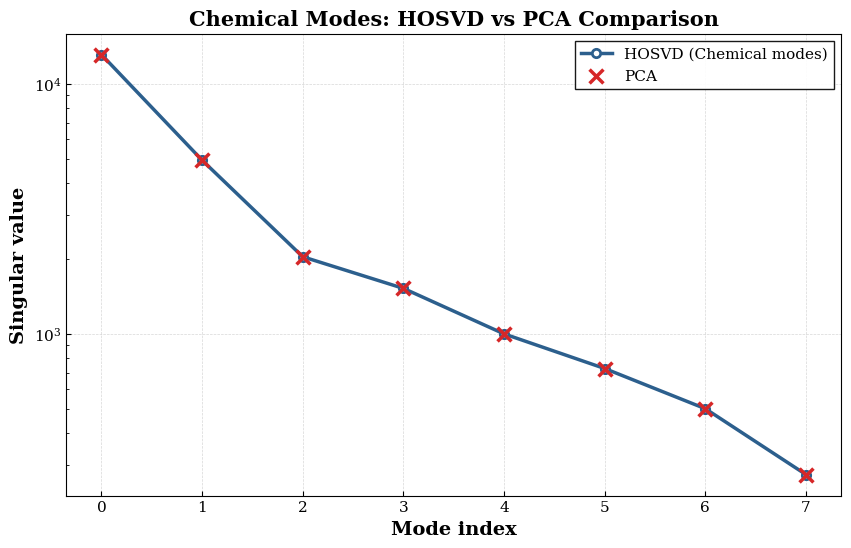

In [ ]:
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 13
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['xtick.labelsize'] = 11
plt.rcParams['ytick.labelsize'] = 11
plt.rcParams['legend.fontsize'] = 11
plt.rcParams['figure.titlesize'] = 14
sv_chem = np.array([np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])]) #as per definition
fig, ax = plt.subplots(figsize=(5, 3))
hosvd_color = '#2C5F8D'  
pca_color = '#D62728'    
ax.plot(range(len(sv_chem)), sv_chem, 'o-', color=hosvd_color, linewidth=2.5, 
        markersize=6, markerfacecolor='white', markeredgewidth=2, 
        label='HOSVD (Chemical modes)', zorder=2)
ax.scatter(range(len(sigma_PCA)), sigma_PCA, marker='x', s=100, 
           color=pca_color, linewidths=2.5, label='PCA', zorder=3)
ax.set_xlabel('Mode index', fontweight='bold', fontsize=14)
ax.set_ylabel('Singular value', fontweight='bold', fontsize=14)
ax.set_title('Chemical Modes: HOSVD vs PCA Comparison', fontweight='bold', fontsize=15)
ax.set_yscale('log')
ax.grid(True, alpha=0.5, linestyle='--', linewidth=0.5)
ax.legend(loc='upper right', frameon=True, fancybox=False, edgecolor='black', framealpha=0.9)
ax.tick_params(direction='in', which='both', labelsize=11)

plt.savefig('README_PLOTS/sing_vals_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


# HOSVD generalized singular value plot

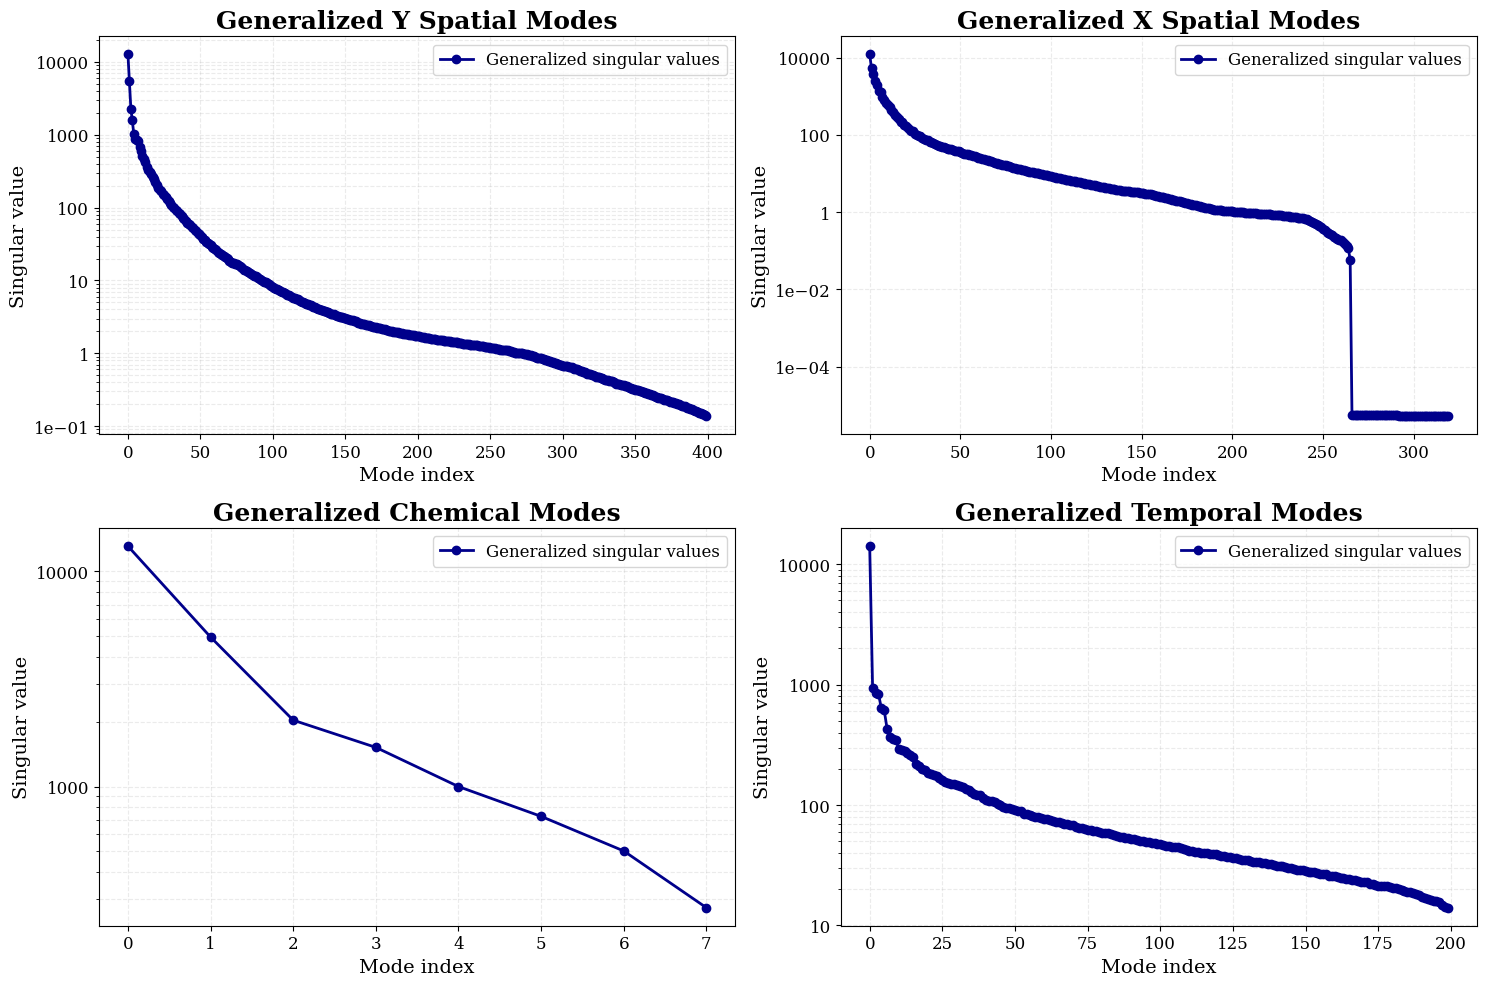

In [115]:
from matplotlib.ticker import LogFormatter

# Slight variation from the plot reported in the paper, but the qualitative results are exactly the same
color = 'darkblue'
label = 'Generalized singular values'

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

sv_y = np.array([np.linalg.norm(core[i, :, :, :]) for i in range(core.shape[0])])
sv_x = np.array([np.linalg.norm(core[:, i, :, :]) for i in range(core.shape[1])])
sv_chem = np.array([np.linalg.norm(core[:, :, i, :]) for i in range(core.shape[2])])
sv_time = np.array([np.linalg.norm(core[:, :, :, i]) for i in range(core.shape[3])])

def style_axis(ax, title, xlabel):
    ax.set_title(title, fontsize=18, weight="bold")
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel("Singular value", fontsize=14)

    ax.set_yscale("log")
    ax.grid(True, which="both", linestyle="--", alpha=0.25)
    ax.tick_params(axis='both', labelsize=12)

    ax.yaxis.set_major_formatter(LogFormatter(labelOnlyBase=False))

ax = axes[0, 0]
ax.plot(sv_y, color=color, linewidth=2, label=label, marker = "o")
style_axis(ax, "Generalized Y Spatial Modes", "Mode index")
ax.legend(fontsize=12, loc="upper right")

ax = axes[0, 1]
ax.plot(sv_x, color=color, linewidth=2, label=label, marker = "o")
style_axis(ax, "Generalized X Spatial Modes", "Mode index")
ax.legend(fontsize=12, loc="upper right")

ax = axes[1, 0]
ax.plot(sv_chem, color=color, linewidth=2, label=label, marker = "o")

#ax.plot(sigma_PCA, color='red', linewidth=2, alpha=0.7, label="PCA singular values")

style_axis(ax, "Generalized Chemical Modes", "Mode index")
ax.legend(fontsize=12, loc="upper right")

ax = axes[1, 1]
ax.plot(sv_time, color=color, linewidth=2, label=label, marker = "o")
style_axis(ax, "Generalized Temporal Modes", "Mode index")
ax.legend(fontsize=12, loc="upper right")
plt.savefig('README_PLOTS/hosvd_core_vals.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()
